<a href="https://colab.research.google.com/github/Simoni2412/Wrinkles-Detection/blob/main/Unet_CNN_for_wrinkles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install mediapipe==0.10.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.7
    Uninstalling protobuf-4.25.7:
      Successfully uninstalled protobuf-4.25.7
  Attempting uninstall: mediapipe
    Found existing installation: mediapipe 0.10.21
    Uninstalling mediapipe-0.10.21:
      Successfully uninstalled mediapipe-0.10.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is inc

In [4]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Mediapipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# T-zone: Full forehead + nose bridge + down to chin
t_zone_indices = [162,21,54,103,67,109,10,338,297,332,284,251,301,300,293,334,296,336,285,413,464,357,277,371,423,391,393,164,167,165,203,142,47,128,244,189,55,107,66,105,63,70,139]

# U-zone: Cheeks + jawline excluding the T-zone
u_zone_indices = [452, 451, 450, 449, 448, 261, 265, 372, 345, 352, 376,433, 288, 367, 397, 365, 379, 378, 400, 377, 152,148, 176, 149, 150, 136, 135, 192, 123, 116, 143, 35, 31,
                  228, 229, 230, 231, 232, 233, 47, 142, 203, 92, 57, 43, 106, 182, 83, 18, 313, 406, 335, 273, 287, 410, 423, 371, 277, 453]
# ButterFly zone
b_zone_indices = [111, 117, 119, 120, 121, 128, 122, 6, 351, 357, 350, 349, 348, 347, 346, 345, 352, 376, 433, 416, 434, 432, 410, 423, 278, 344, 440, 275, 4, 45, 220, 115, 48, 203, 186,
                  186, 212, 214, 192, 123, 116]

# Function to draw T-zone and U-zone masks
def detect_zones(image_path):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(rgb_image)
    if not results.multi_face_landmarks:
        print("No face detected.")
        return

    landmarks = results.multi_face_landmarks[0]

    t_points = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in t_zone_indices]
    u_points = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in u_zone_indices]
    b_points = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in b_zone_indices]

    # Create mask
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(t_points, dtype=np.int32)], 1)  # T-zone
    cv2.fillPoly(mask, [np.array(u_points, dtype=np.int32)], 2)  # U-zone
    cv2.fillPoly(mask, [np.array(b_points, dtype=np.int32)], 3)  # B-zone

    # Visualization overlay
    overlay = image.copy()
    overlay[mask == 1] = [255, 0, 0]    # T-zone in Blue
    overlay[mask == 2] = [0, 255, 0]    # U-zone in Green
    overlay[mask == 3] = [0, 0, 255]    # B-zone in Red
    output = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)

    # Save the overlay image for later extraction
    cv2.imwrite(image_path, overlay)  # BGR format by default

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("T-zone (blue), U-zone (green)")
    plt.axis('off')
    plt.show()



# def draw_landmarks(image_path, show_ids=False):
#     image = cv2.imread(image_path)
#     h, w = image.shape[:2]
#     rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     results = face_mesh.process(rgb_image)
#     if not results.multi_face_landmarks:
#         print("No face detected.")
#         return

#     # Get the first face
#     #landmarks = results.multi_face_landmarks[0]

#     # Draw all 468 points
#     for facial_landmarks in results.multi_face_landmarks:
#       for i in range(0,468):
#         pt1x = int(facial_landmarks.landmark[i].x * w)
#         pt1y = int(facial_landmarks.landmark[i].y * h)
#         cv2.circle(image, (pt1x, pt1y), 1, (0,255,0), -1)
#         cv2.putText(image, str(i), (pt1x, pt1y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,0), 1)
#     # for idx, lm in enumerate(landmarks.landmark):
#     #     x, y = int(lm.x * w), int(lm.y * h)
#     #     cv2.circle(image, (x, y), 1, (0, 255, 255), -1)  # Yellow dot
#     #     if show_ids:
#     #         cv2.putText(image, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)

    # Show result
    # plt.figure(figsize=(15, 15))
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.title("Face Landmarks" + (" with IDs" if show_ids else ""))
    # plt.axis('off')
    # plt.show()



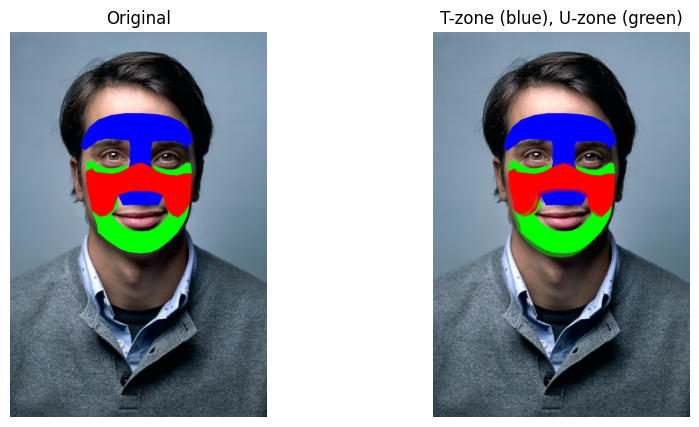

In [5]:
image = detect_zones("/content/drive/MyDrive/Segmentation data /Train/face.jpg")

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

def load_segmentation_data(image_dir, mask_dir, target_size=(256, 256), num_classes=4):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        img = Image.open(os.path.join(image_dir, filename)).resize(target_size)
        mask = Image.open(os.path.join(mask_dir, filename)).resize(target_size, Image.NEAREST)

        images.append(np.array(img) / 255.0)
        masks.append(to_categorical(np.array(mask), num_classes=num_classes))

    return np.array(images), np.array(masks)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Input, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

# ---- Attention Module ----
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1,1), padding="same")(x)
    phi_g = Conv2D(inter_channels, (1,1), padding="same")(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = tf.keras.activations.relu(add_xg)
    psi = Conv2D(1, (1,1), padding="same", activation="sigmoid")(act_xg)
    return Multiply()([x, psi])

# ---- Gaussian Filter ----
class GaussianFilterLayer(Layer):
    def __init__(self, **kwargs):
        super(GaussianFilterLayer, self).__init__(**kwargs)

    def call(self, x):
        gaussian_kernel = tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)
        gaussian_kernel = gaussian_kernel[:, :, None, None] / 16  # Normalized kernel
        gaussian_kernel = tf.repeat(gaussian_kernel, repeats=x.shape[-1], axis=-1)
        return tf.nn.conv2d(x, filters=tf.cast(gaussian_kernel, tf.float32), strides=[1,1,1,1], padding="SAME")

# ---- Reduced U-Net ----
def reduced_unet(input_shape=(128,128,3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)

    # Decoder
    up2 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(conv3)
    attn2 = attention_block(conv2, up2, 64)
    merge2 = Add()([up2, attn2])
    conv4 = Conv2D(64, (3,3), activation="relu", padding="same")(merge2)

    up1 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(conv4)
    attn1 = attention_block(conv1, up1, 32)
    merge1 = Add()([up1, attn1])
    conv5 = Conv2D(32, (3,3), activation="relu", padding="same")(merge1)

    # Apply Gaussian Filter for Edge Detection
    edge_detect = GaussianFilterLayer()(conv5)

    output_layer = Conv2D(1, (1,1), activation="sigmoid", padding="same")(edge_detect)

    return Model(inputs, output_layer)

# Build Model
model = reduced_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_28[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_30[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_32[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │     32,832 │ conv2d_33[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │      4,160 │ conv2d_31[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 64,    │      4,160 │ conv2d_transpose… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 64, 64,    │          0 │ conv2d_34[0][0],  │
│                     │ 64)               │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 64, 64,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64, 1) │         65 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 64, 64,    │          0 │ conv2d_31[0][0],  │
│ (Multiply)          │ 64)               │            │ conv2d_36[0][0] 

 Total params: 384,803 (1.47 MB)

 Trainable params: 384,803 (1.47 MB)

 Non-trainable params: 0 (0.00 B)